# This Notebook looks at Titanic Survival Data using SparkML
## First Connect to Koverse

## Then retrieve data into Spark DataFrame

In [1]:
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

from timeit import default_timer as timer

from kdp_connector import KdpConn

# This example shows you how to use the KDP Python Connector to read data from KDP dataset into
# a Pandas Dataframe..

email = 'yaddayadda@koverse.com'
password = "???"
workspace_id = 'enytest1'
dataset_id = 'd956ba93-8b4b-49eb-859e-8829b51652e1'
host = 'https://api.dev.koverse.com'
batch_size = 100000
starting_record_id = ''
path_to_ca_file = ''
kdp_conn = KdpConn(path_to_ca_file=path_to_ca_file, host=host)
jwt = kdp_conn.create_authentication_token(email=email,password=password,workspace_id=workspace_id)
pDF = kdp_conn.read_dataset_to_pandas_dataframe(dataset_id=dataset_id,
                                                      jwt=jwt,
                                                      starting_record_id=starting_record_id,
                                                      batch_size=batch_size)

In [2]:
from pyspark.sql import SparkSession
#Create PySpark SparkSession
spark = SparkSession.builder \
    .master("local[1]") \
    .appName("temp1") \
    .getOrCreate()

In [3]:

df=spark.createDataFrame(pDF) 
df.printSchema()
df.show(10)

root
 |-- Embarked: string (nullable = true)
 |-- Survived: string (nullable = true)
 |-- Pclass: string (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- PassengerId: string (nullable = true)
 |-- Parch: string (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- SibSp: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Fare: string (nullable = true)

+--------+--------+------+---------------+-----------+-----+-----+------+-----+---+--------------------+-------+
|Embarked|Survived|Pclass|         Ticket|PassengerId|Parch|Cabin|   Sex|SibSp|Age|                Name|   Fare|
+--------+--------+------+---------------+-----------+-----+-----+------+-----+---+--------------------+-------+
|       Q|       0|     3|         330877|          6|    0|     |  male|    0|   |     Moran Mr. James| 8.4583|
|       S|       1|     2|     C.A. 34651|        473|    2|     |female|    1| 33|West Mr

## Explore with SQL

In [4]:
df.createOrReplaceTempView("titanicTemp")
result = spark.sql('''
   SELECT sex, AVG(age) as avg_age
   FROM titanicTemp
   GROUP BY sex
   ''')
result.show()


+------+------------------+
|   sex|           avg_age|
+------+------------------+
|female|27.915708812260537|
|  male| 30.72664459161148|
+------+------------------+



## Explore data using a dataframe or using Pandas

In [5]:
pDF.info(verbose=True)
pDF.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Embarked     891 non-null    object
 1   Survived     891 non-null    object
 2   Pclass       891 non-null    object
 3   Ticket       891 non-null    object
 4   PassengerId  891 non-null    object
 5   Parch        891 non-null    object
 6   Cabin        891 non-null    object
 7   Sex          891 non-null    object
 8   SibSp        891 non-null    object
 9   Age          891 non-null    object
 10  Name         891 non-null    object
 11  Fare         891 non-null    object
dtypes: object(12)
memory usage: 83.7+ KB


,Embarked,Survived,Pclass,Ticket,PassengerId,Parch,Cabin,Sex,SibSp,Age,Name,Fare
count,891,891,891,891,891,891,891,891,891,891,891,891
unique,4,2,3,681,891,7,148,2,7,89,891,248
top,S,0,3,347082,559,0,,male,0,,Saundercock Mr. William Henry,8.05
freq,644,549,491,7,1,678,687,577,608,177,1,43


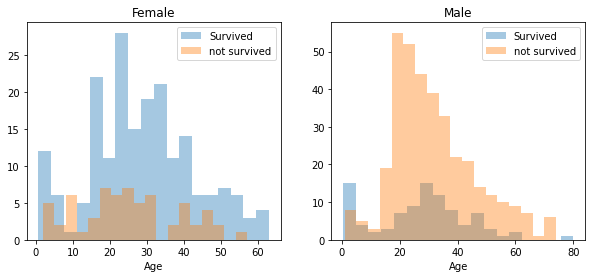

In [6]:
# https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
pDF["Survived"] = pd.to_numeric(pDF["Survived"])
pDF["Age"] = pd.to_numeric(pDF["Age"])
pDF["Sex"] = pDF["Sex"].astype(str)
survived = 'Survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = pDF[pDF['Sex']=='female']
men = pDF[pDF['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=18, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=18, label = not_survived, ax = axes[1], kde = False)
ax.legend()
ax = ax.set_title('Male')

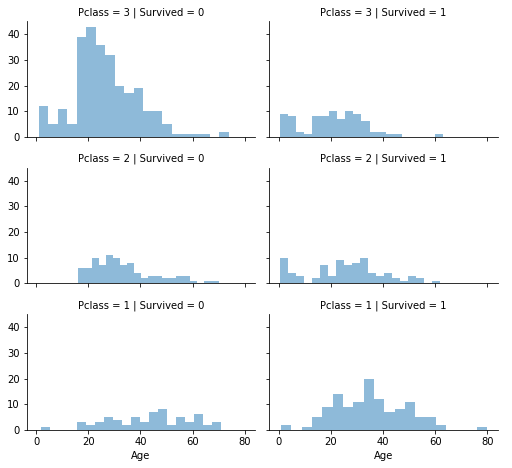

In [7]:
grid = sns.FacetGrid(pDF, col='Survived', row='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

## Create Features to be used in model

In [8]:
import pyspark.sql.functions as F
mean = int(pDF["Age"].mean())
print(mean,type(mean))

df2 = df.withColumn("male", (F.when(F.col("Sex") == 'male', 1).otherwise(0)))
df2 = df2.withColumn("Age",df2.Age.cast('int'))
df2 = df2.withColumn("embarked_num", (F.when(F.col("Embarked") == 'Q', 1).otherwise(0)))
df2 = df2.withColumn("age_new", (F.when(F.col("Age").isNull() | F.isnan(F.col("Age")), mean).otherwise(F.col("Age").cast('int'))))
df2 = df2.withColumn("Parch",df2.Parch.cast('int'))
df2 = df2.withColumn("Pclass",df2.Pclass.cast('int'))
df2 = df2.withColumn("SibSp",df2.SibSp.cast('int'))
df2 = df2.withColumn("Survived",df2.Survived.cast('int'))
df2 = df2.withColumn("embarked_num",df2.embarked_num.cast('int'))
df2 = df2.withColumn("male",df2.male.cast('int'))
df2 = df2.withColumn("age_new",df2.age_new.cast('int'))


29 <class 'int'>


In [9]:
df2.toPandas()[['age_new','embarked_num', 'male', 'Parch', 'Pclass', 'SibSp']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   age_new       891 non-null    int32
 1   embarked_num  891 non-null    int32
 2   male          891 non-null    int32
 3   Parch         891 non-null    int32
 4   Pclass        891 non-null    int32
 5   SibSp         891 non-null    int32
dtypes: int32(6)
memory usage: 21.0 KB


In [11]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer,VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


cols = ['age_new','embarked_num', 'male', 'Parch', 'Pclass', 'SibSp']


vecassemb = VectorAssembler(inputCols=cols,outputCol='features')
df3 = vecassemb.transform(df2)


df_train, df_test = df3.randomSplit([0.8,0.2])

rf = RandomForestClassifier(featuresCol='features',labelCol='Survived')
model = rf.fit(df_train)
result = model.transform(df_test)


predictionAndLabels = result.select("prediction", "Survived")

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="Survived", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(result)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.171271


In [12]:
all_results = model.transform(df3)
all_results.select('name','survived','prediction').toPandas()

,name,survived,prediction
0,Moran Mr. James,0,0.0
1,West Mrs. Edwy Arthur (Ada Mary Worth),1,1.0
2,"Collyer Miss. Marjorie ""Lottie""",1,1.0
3,Hoyt Mr. William Fisher,0,0.0
4,McMahon Mr. Martin,0,0.0
...,...,...,...
886,Dennis Mr. Samuel,0,0.0
887,Silvey Mrs. William Baird (Alice Munger),1,1.0
888,Kallio Mr. Nikolai Erland,0,0.0
889,Brown Mr. Thomas William Solomon,0,0.0


Text(0.5, 1.0, 'Feature Importances')

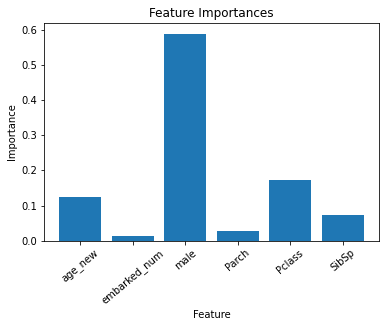

In [13]:
importances = model.featureImportances

x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, cols, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

In [30]:
all_results

DataFrame[Embarked: string, Survived: int, Pclass: int, Ticket: string, PassengerId: string, Parch: int, Cabin: string, Sex: string, SibSp: int, Age: int, Name: string, Fare: string, male: int, embarked_num: int, age_new: int, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [51]:

dfOut = all_results.toPandas()[['age_new','embarked_num', 'male', 'Parch', 'Pclass', 'SibSp','Name','Survived','prediction']]
dfOut.Name = dfOut.Name.astype('string')
dfOut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age_new       891 non-null    int32  
 1   embarked_num  891 non-null    int32  
 2   male          891 non-null    int32  
 3   Parch         891 non-null    int32  
 4   Pclass        891 non-null    int32  
 5   SibSp         891 non-null    int32  
 6   Name          891 non-null    string 
 7   Survived      891 non-null    int32  
 8   prediction    891 non-null    float64
dtypes: float64(1), int32(7), string(1)
memory usage: 38.4 KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   age_new       891 non-null    int32
 1   embarked_num  891 non-null    int32
 2   male          891 non-null    int32
 3   Parch         891 non-null    int32
 4   Pclass        891 non-null    int32
 5   SibSp         891 non-null    int32
dtypes: int32(6)
memory usage: 21.0 KB


## Save back to Koverse

In [53]:
# ingest data
partitions_set = kdp_conn.ingest(dfOut, "5ffbfb5b-6394-4d60-836f-ef99fc582d06", jwt, batch_size)

pprint('partitions: %s' % partitions_set)

'partitions: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}'
